In [ ]:
import os
import cv2
import pytesseract

# # Get the current working directory and image path
project_dir = os.getcwd()

# Get the current working directory and move one directory up
# project_dir = os.path.dirname(os.getcwd())

# Construct the image path from the project directory
image_path = os.path.join(project_dir, "data_unique", "Original_2.png")

# Load the image
img = cv2.imread(image_path)

# Preprocess the image (if necessary)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# Apply thresholding to make the image binary
_, thresh = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY)

# Configure Tesseract to recognize digits only and output symbol-level data
custom_config = r'--oem 3 --psm 8 -c tessedit_char_whitelist=0123456789'

# Perform OCR with detailed data output at the symbol level
data = pytesseract.image_to_data(thresh, config=custom_config, output_type=pytesseract.Output.DICT)

# Extract character-level details
recognized_chars = []

n_boxes = len(data['text'])
for i in range(n_boxes):
    text = data['text'][i].strip()
    if text.isdigit():
        recognized_chars.append(text)
# Print the recognized digits
print("Recognized Digits:")
for char in recognized_chars:
    print(f"Number: {char}")


Recognized Digits:
Number: 542047


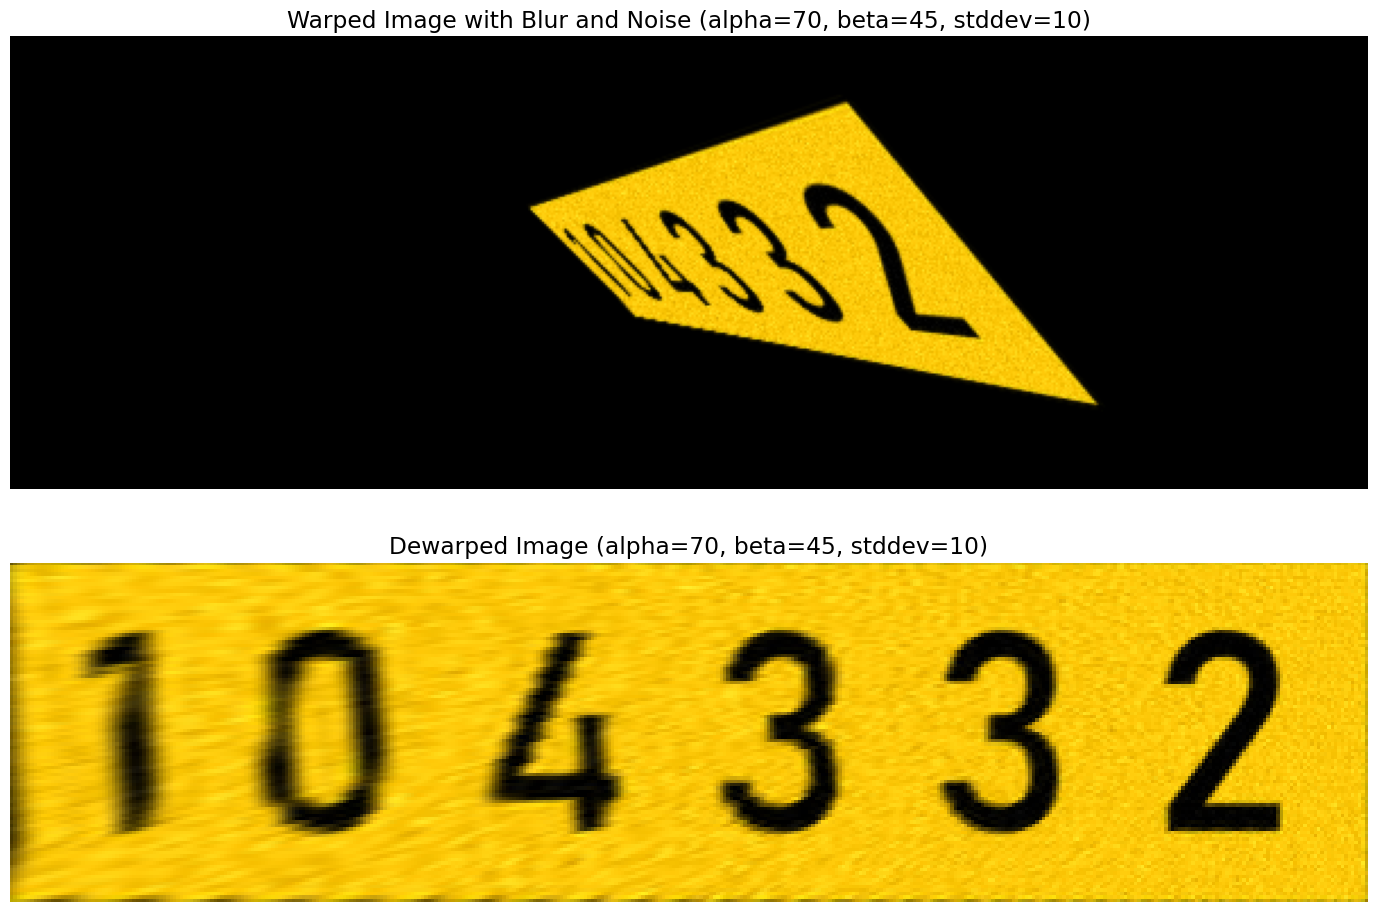

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
from PIL import Image, ImageDraw, ImageFont

random.seed(42)
np.random.seed(42)

def generate_plate_number():
    return " ".join([str(random.randint(0, 9)) for _ in range(6)])

def create_license_plate():
    plate_number = generate_plate_number()
    width, height = 400, 100
    background_color = (255, 203, 9)
    text_color = (0, 0, 0)
    text_size = 82

    image = Image.new("RGB", (width, height), background_color)
    draw = ImageDraw.Draw(image)
    try:
        font = ImageFont.truetype("bahnschrift.ttf", text_size)
    except IOError:
        font = ImageFont.load_default()
    text_bbox = draw.textbbox((0, 0), plate_number, font)
    text_width, text_height = text_bbox[2] - text_bbox[0], text_bbox[3] - text_bbox[1]
    text_x = (width - text_width) // 2 - text_bbox[0]
    text_y = (height - text_height) // 2 - text_bbox[1]
    draw.text((text_x, text_y), plate_number, fill=text_color, font=font)

    new_width, new_height = int(width * 1.5), int(height * 2)
    new_image = Image.new("RGB", (new_width, new_height), (0, 0, 0))
    x1, y1 = (new_width - width) // 2, (new_height - height) // 2
    corners = [(x1, y1), (x1 + width, y1), (x1 + width, y1 + height), (x1, y1 + height)]
    new_image.paste(image, (x1, y1))

    return new_image, corners

def calculate_center(points):
    return np.mean(points[:, 0]), np.mean(points[:, 1])

def warp_image(image, src_points, alpha, beta, f=400):
    alpha_rad, beta_rad = np.deg2rad(alpha), np.deg2rad(beta)
    R_y = np.array([[np.cos(alpha_rad), 0, np.sin(alpha_rad)], [0, 1, 0], [-np.sin(alpha_rad), 0, np.cos(alpha_rad)]])
    R_x = np.array([[1, 0, 0], [0, np.cos(beta_rad), -np.sin(beta_rad)], [0, np.sin(beta_rad), np.cos(beta_rad)]])
    R = np.dot(R_y, R_x)
    center = calculate_center(np.array(src_points))
    dst_points = []
    for point in src_points:
        x, y = point[0] - center[0], point[1] - center[1]
        vec = np.dot(R, np.array([x, y, 0]))
        x_proj = center[0] + f * (vec[0] / (f + vec[2]))
        y_proj = center[1] + f * (vec[1] / (f + vec[2]))
        dst_points.append([x_proj, y_proj])
    M = cv2.getPerspectiveTransform(np.float32(src_points), np.float32(dst_points))
    return cv2.warpPerspective(image, M, (image.shape[1], image.shape[0]), flags=cv2.INTER_LANCZOS4), dst_points

def add_fine_grain_noise(image, dst_points, stddev=10, alpha=0.4, beta=0.6):
    # Create a mask based on the destination points
    mask = np.zeros(image.shape[:2], dtype=np.uint8)
    cv2.fillPoly(mask, [np.int32(dst_points)], 255)

    # Convert image to YCrCb color space
    ycrcb_image = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
    Y, Cr, Cb = cv2.split(ycrcb_image)

    # Generate Gaussian noise
    noise = np.random.normal(0, stddev, Y.shape).astype(np.float32)

    # Scale noise: minimal in dark areas, more in bright areas
    noise_scaled = noise * (alpha + beta * (Y / 255.0))

    # Apply scaled noise only in the masked area
    Y_noisy = np.clip(Y + np.where(mask == 255, noise_scaled, 0), 0, 255).astype(np.uint8)

    # Merge back the noisy Y channel with the original Cr and Cb channels
    noisy_ycrcb_image = cv2.merge([Y_noisy, Cr, Cb])
    noisy_bgr_image = cv2.cvtColor(noisy_ycrcb_image, cv2.COLOR_YCrCb2BGR)

    return noisy_bgr_image

def add_realistic_noise(image, dst_points, stddev=10, alpha=0.2, beta=0.7, low_freq_scale=0.1):
    """
    Add realistic fine-grained noise with spatial smoothing and non-linear scaling.
    Noise simulates photon shot noise, signal-dependent scaling, and color noise.

    Args:
        image (numpy.ndarray): Input image in BGR format.
        dst_points (numpy.ndarray): Mask area for noise application.
        stddev (float): Standard deviation for the Gaussian noise.
        alpha (float): Base noise scaling factor (dark regions).
        beta (float): Signal-dependent scaling factor.
        low_freq_scale (float): Scaling for low-frequency (spatially smooth) noise.

    Returns:
        numpy.ndarray: The image with realistic fine-grained noise added.
    """
    # Create a mask based on the destination points
    mask = np.zeros(image.shape[:2], dtype=np.uint8)
    cv2.fillPoly(mask, [np.int32(dst_points)], 255)

    # Convert image to YCrCb color space
    ycrcb_image = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
    Y, Cr, Cb = cv2.split(ycrcb_image)

    # Generate Gaussian noise for Y channel (fine-grain)
    fine_noise = np.random.normal(0, stddev, Y.shape).astype(np.float32)

    # Simulate low-frequency noise (spatial smoothing of random noise)
    low_freq_noise = cv2.GaussianBlur(np.random.normal(0, 1, Y.shape).astype(np.float32), (15, 15), 0)
    low_freq_noise *= low_freq_scale * stddev  # Scale low-frequency noise

    # Total noise: Combine fine-grain and low-frequency noise
    total_noise = fine_noise + low_freq_noise

    # Scale noise using photon shot noise model: proportional to sqrt(Y)
    noise_scaled = total_noise * (alpha + beta * np.sqrt(Y / 255.0))

    # Apply scaled noise only in the masked area
    Y_noisy = np.clip(Y + np.where(mask == 255, noise_scaled, 0), 0, 255).astype(np.uint8)

    # Add slight noise to Cr and Cb channels (simulate color noise)
    chroma_noise_stddev = stddev * 0.1  # Less noise in chroma channels
    Cr_noisy = np.clip(Cr + np.random.normal(0, chroma_noise_stddev, Cr.shape), 0, 255).astype(np.uint8)
    Cb_noisy = np.clip(Cb + np.random.normal(0, chroma_noise_stddev, Cb.shape), 0, 255).astype(np.uint8)

    # Merge back noisy Y, Cr, and Cb channels
    noisy_ycrcb_image = cv2.merge([Y_noisy, Cr_noisy, Cb_noisy])
    noisy_bgr_image = cv2.cvtColor(noisy_ycrcb_image, cv2.COLOR_YCrCb2BGR)

    return noisy_bgr_image

def dewarp_image(image, src_points, dst_points):
    M_inv = cv2.getPerspectiveTransform(np.float32(dst_points), np.float32(src_points))
    return cv2.warpPerspective(image, M_inv, (image.shape[1], image.shape[0]), flags=cv2.INTER_LANCZOS4)

def crop_to_original_size(image, width=400, height=100):
    h, w = image.shape[:2]
    x1, y1 = (w - width) // 2, (h - height) // 2
    return image[y1:y1+height, x1:x1+width]


plate_image, src_points = create_license_plate()
plate_image = cv2.cvtColor(np.array(plate_image), cv2.COLOR_RGB2BGR)
alpha, beta, f = 70, 45, 400

# Warp the image
warped_image, dst_points = warp_image(plate_image, src_points, alpha, beta, f)
warped_image_rgb = cv2.cvtColor(warped_image, cv2.COLOR_BGR2RGB)

# Apply Gaussian blur BEFORE adding noise
blur_kernel_size = (3, 3)  # Adjust kernel size for stronger/weaker blur
blurred_warped_image = cv2.GaussianBlur(warped_image, blur_kernel_size, sigmaX=0.5, sigmaY=0.5)

# Add fine-grained luminance noise AFTER blurring
stddev = 10
noisy_warped_image_bgr = add_fine_grain_noise(blurred_warped_image, dst_points, stddev=stddev, alpha=0.4, beta=0.6)
noisy_warped_image_rgb = cv2.cvtColor(noisy_warped_image_bgr, cv2.COLOR_BGR2RGB)

# Dewarp the image
dewarped_image = dewarp_image(cv2.cvtColor(noisy_warped_image_rgb, cv2.COLOR_RGB2BGR), src_points, dst_points)
dewarped_cropped = crop_to_original_size(cv2.cvtColor(dewarped_image, cv2.COLOR_BGR2RGB))

# Plot results
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Warped Image with Blur and Noise (Extended)
axes[0].imshow(noisy_warped_image_rgb)
axes[0].axis('off')
axes[0].set_title(f'Warped Image with Blur and Noise (alpha={alpha}, beta={beta}, stddev={stddev})')

# Dewarped Image (Cropped)
axes[1].imshow(dewarped_cropped)
axes[1].axis('off')
axes[1].set_title(f'Dewarped Image (alpha={alpha}, beta={beta}, stddev={stddev})')

plt.rcParams.update({'font.size': 14})

plt.tight_layout()
plt.show()

